In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

### Animelist.csv 

In [2]:
import os
INPUT_DIR = os.path.join("..","artifacts","raw")

In [3]:
rating_df =pd.read_csv(INPUT_DIR+"/animelist.csv",low_memory=True,usecols=["user_id","anime_id","rating"])

In [4]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [5]:
len(rating_df)

5000000

### Data Processing

In [6]:
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [7]:
len(rating_df)

3246641

In [8]:
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])

In [9]:
min_rating,max_rating

(0, 10)

In [10]:
avg_rating =np.mean(rating_df['rating'])
avg_rating

np.float64(4.122732695114736)

In [11]:
### Min Max Scaling
rating_df['rating'] = rating_df["rating"].apply(lambda x:((x-min_rating)/max_rating-min_rating)).values.astype(np.float64)

In [12]:
np.max(rating_df['rating'])

np.float64(1.0)

In [13]:
rating_df.duplicated().sum()

np.int64(0)

In [14]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [15]:
user_ids = rating_df['user_id'].unique().tolist()
### Enocde users making the user_id -> index
user2user_encoded= {x:i for i, x in enumerate(user_ids)}
user2user_decoded ={i:x for i,x in enumerate(user_ids)}
rating_df["user"] = rating_df['user_id'].map(user2user_encoded)

In [16]:
n_users = len(user2user_encoded)
n_users

4203

In [17]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [18]:
# same maping for anime_id
anime_rating = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x:i for i,x in enumerate(anime_rating)}
anime2anime_decoded = {i:x for i,x in enumerate(anime_rating)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded)

In [19]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [20]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1


In [21]:
rating_df =rating_df.sample(frac=1,random_state=42).reset_index(drop=True) # reset_index :resests the index to from 0-N-1 else the index will also be randomized

In [22]:
X = rating_df[['user','anime']].values

In [23]:
y= rating_df['rating'].values

In [24]:
len(rating_df)

3246641

In [25]:
test_size=1000
train_size = rating_df.shape[0] - test_size

In [26]:
X_train,X_test,y_train,y_test = (
    X[:train_size],
    X[train_size:],
    y[:train_size],
    y[train_size:]
)

In [27]:
len(X_train),len(X_test)

(3245641, 1000)

In [28]:
type(X_train),type(y_test)

(numpy.ndarray, numpy.ndarray)

In [29]:
X_train

array([[3405,  688],
       [4060, 1518],
       [1213, 4963],
       ...,
       [ 560, 1461],
       [3815, 1512],
       [2122, 1153]])

In [30]:
X_test

array([[1623, 1398],
       [3761, 1577],
       [2203, 7925],
       ...,
       [2881, 5028],
       [3569,  175],
       [2870, 1895]])

In [31]:
X_train_array = [X_train[:,0],X_train[:,1]]
X_test_array = [X_test[:,0],X_test[:,1]]

In [32]:
type(X_test_array)

list

In [33]:
type(X_test_array[1])

numpy.ndarray

#### MODEL ARCHITECTURE

In [34]:
def RecommenderNet():
    embedding_size= 128

    user =Input(name="user",shape=[1])
    user_embedding =Embedding(name="user_embeddings",input_dim=n_users,output_dim=embedding_size)(user)

    anime=Input(name="anime",shape=[1])
    anime_embedding =Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x=Dot(name="Dot_Product",normalize=True,axes =2)([user_embedding,anime_embedding])# dot product to find similarity between user and anime

    x= Flatten()(x)
    x= Dense(1,kernel_initializer='he_normal')(x)
    x=BatchNormalization()(x)
    x=Activation("sigmoid")(x)

    model =Model(inputs=[user,anime],outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer="adam")
    return model



In [35]:
model=RecommenderNet()

In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embeddings     │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dot_Product (Dot)   │ (None, 1, 1)      │          0 │ user_embeddings[… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ Dot_Product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [37]:
start_lr =0.00001
min_lr=0.0001
max_lr=0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay =0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (start_lr + (epoch/ramup_epochs) * (max_lr-start_lr))
    elif epoch < (ramup_epochs+sustain_epochs):
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch -ramup_epochs-sustain_epochs)+min_lr

In [38]:
lr_callbacks =LearningRateScheduler(lambda epoch:lrfn(epoch),verbose=0)
checkpoint_filepath='./weights.weights.h5'

model_checkpoint=ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)
early_stopping = EarlyStopping(patience=3,monitor='val_loss',mode="min",restore_best_weights=True)


In [39]:
my_callbacks = [model_checkpoint,early_stopping,lr_callbacks]

In [40]:
# history = model.fit(
#     x=X_train_array,
#     y=y_train,
#     batch_size=batch_size,
#     epochs=20,
#     verbose = 1,
#     validation_data = (X_test_array,y_test),    
#     callbacks =my_callbacks
# )

In [41]:
model.load_weights(checkpoint_filepath)

c:\Users\91835\OneDrive\Desktop\mlops_project2\project2\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
# metrics = ['loss','mae','mse']

# fig ,axes =plt.subplots(len(metrics),1,figsize = (8,len(metrics)*4))

# for i,metric in enumerate(metrics):
#     ax=axes[i]
#     ax.plot(history.history[metric][0:-2],marker="o",label =f"train {metric}")
#     ax.plot(history.history[f"val_{metric}"][0:-2],marker="o",label =f"test {metric}")
#     ax.set_title(f"Model's {metric}")
#     ax.set_ylabel(metric)
#     ax.set_xlabel("Epoch")
#     ax.legend(loc="upper left")
#     ax.grid(True)

# plt.show()

In [43]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights =weight_layer.get_weights()[0]

    weights =weights /np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights 


In [44]:
anime_weights = extract_weights("anime_embedding",model)

In [45]:
user_weights = extract_weights("user_embeddings",model)

### Amine.csv

In [46]:
df=pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [47]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [48]:
df =df.replace("Unknown",np.nan)

In [49]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id]["English name"].values[0]
        if name is np.nan:
            name= df[df.anime_id == anime_id]["Name"].values[0]
    except Exception as e:
        print("Error",e)
    return name

In [50]:
df["anime_id"]=df['MAL_ID']

In [51]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1


In [52]:
df['eng_version']=df['MAL_ID'].apply(getAnimeName)

In [53]:
df.sort_values(by=['Score'],
               inplace=True,
               ascending=False,
               na_position="last")

In [54]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season


In [55]:
df=df[["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [56]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [57]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id==anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [58]:
getAnimeFrame("Attack on Titan Final Season",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


### Anime with Synopsis

In [59]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [60]:
sypnopsis_df = pd.read_csv(INPUT_DIR+'/anime_with_synopsis.csv',low_memory=True,usecols=cols)

In [61]:
sypnopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."


In [85]:
def getSynopsis(anime,sypnopsis_df):
    if isinstance(anime,int):
        return sypnopsis_df[sypnopsis_df.MAL_ID == anime]["sypnopsis"].values[0]
    if isinstance(anime,str):
        return sypnopsis_df[sypnopsis_df.Name == anime]["sypnopsis"][0]

In [86]:
getSynopsis(40028,sypnopsis_df=sypnopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

# Content/Item based Recommendation System

In [64]:
pd.set_option("max_colwidth",None)

In [89]:
def find_similar_animes(name,anime_weights,anime2anime_encoded,
                        anime2anime_decoded,df,sypnopsis_df,n=10,return_dist=False,negative=False):# negative=True disimilar items ,False Similar animes
    # try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        
        encoded_index =anime2anime_encoded.get(index)

        weights = anime_weights
        dists = np.dot(weights,weights[encoded_index])
        sorted_dist = np.argsort(dists) # argsort gives the indexes needed for sorting
        n+=1

        if negative:
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]
        
        print(f"Anime closest to {name}")

        if return_dist:
            return dists,closest

        similarityArr =[]
        for closes in closest:
            decoded_id  = anime2anime_decoded.get(closes)

            anime_frame =getAnimeFrame(decoded_id,df)
            anime_name =anime_frame.eng_version.values[0]
            genre =anime_frame.Genres.values[0]
            similarity =dists[closes]
            similarityArr.append({
                "anime_id":decoded_id,
                "name":anime_name,
                "similarity":similarity,
                "genre":genre,
                

            })
        Frame =pd.DataFrame(similarityArr).sort_values(by="similarity",ascending=False)
        return Frame[Frame.anime_id!=index].drop(["anime_id"],axis=1)
    # except Exception as e:
    #     print("Error occured",e)

In [66]:

find_similar_animes("Steins;Gate",anime_weights,anime2anime_encoded,anime2anime_decoded,df,sypnopsis_df,)

Anime closest to Steins;Gate


,name,similarity,genre,synopsis
9,Guru Guru Town Hanamaru-kun,0.320327,Kids,Guru Guru Town Hanamaru-kun follows the life of some children in a fictional town.
8,Crayon Shin-chan Movie 02: Buriburi Oukoku no Hihou,0.315955,"Action, Adventure, Comedy, Seinen","action adventure film set in a imaginary southern island in the Indian Ocean. The evil secret society, ""White Snake"" abducted Shinnosuke and Prince Sunnokeshi of the Buri Buri Kingdom, who looks very much like Shinnosuke, in order to get the kingdom's hidden treasure in the golden palace underground. Shinnosuke's parents, Hiroshi and Misae fight with Lulu, the major of the palace guard of the kingdom, against White Snake, trying to recapture Shinnosuke and the prince. (Source: Manabu Tsuribe)"
7,PiKA PiKA,0.301773,NaN,"stract short film, the first ""lightning doodle"" film by Tochka."
6,Magical Girl Lyrical Nanoha Reflection,0.300415,"Action, Drama, Magic, Sci-Fi","pair of researchers stays behind on their dying planet of Eltria with their two daughters, Amitie and Kirie, in hopes of finding a way to revive the planet. But when the husband Granz falls ill it seems their dream of reviving the planet will die. Against her older sister's wishes, Kirie sets off with her childhood friend Iris to seek help from a distant alternate world. They arrive in Japan on Earth to search for the key to their planet's regeneration. There, they meet Nanoha, Fate, and Hayate. (Source: ANN)"
5,I'm Here with You,0.298833,"Music, Kids",gentle song about the earth by Mimori Yusa that was featured on NHK's Minna no Uta.
4,Konjiki no Gash Bell!!: Ougon no Chichi wo Motsu Otoko,0.289914,"Action, Adventure, Comedy, Ecchi, Kids, Magic, Romance, Super Power, Supernatural","Folgore - 00F, the world's most ultimate spy is set on retrieving the stolen boobs. Watch as many of the characters from the original series (Konjiki no Gash Bell) are given life anew in this alternate setting."
3,Super Doll Licca-chan: Licca-chan Zettai Zetsumei! Doll Knights no Kiseki,0.283109,"Action, Adventure, Super Power, Kids, Magic, Fantasy, Shoujo","fun day at the amusement park is interrupted when the evil witch Dana is reawakened. Queen Yae has sent her after Rika and only the Doll Knights can stop this threat. Meanwhile, Dai and the others must deal with other dangers. (Source: ANN)"
2,Kiddy GiRL-AND Pilot,0.280380,"Action, Super Power, Sci-Fi","ES members Éclair and Lumière once were involved in a battle to decide the fate of the galaxy. They prevailed and peace was restored to the galaxy. Now, several years later, the galaxy once again stands on the brink of chaos. This conflict will see the dawn of two new heroines; Ascoeur and Q-feuille."
1,Shinshaku Sengoku Eiyuu Densetsu: Sanada Juu Yuushi The Animation,0.276130,"Action, Comedy, Historical, Military, Samurai","In the Fifth Year of the Keicho era, the Tokugawa clan sought to solidify their control of Japan. Hidetada Tokugawa has come to the doorsteps of Ueda Castle with the intentions of having the Sanada clan open its doors to him. But the Sanada and their retainers have other plans... (Source: ANN)"
0,Asunal Kanayama,0.275079,Slice of Life,"mated commercials for Asunal Kanayama , a large open-air mall in Nagoya. There are 3 separate Fair commercials from 2013 but besides the dialogue and a change in the background color, the animation remains identical. As such, MAL will reflect this trio as a single episode."


# Colabaorative Function

In [67]:
def find_similar_users(item_input,user_weights,user2user_encoded,user2user_decoded,n=10,return_dist = False,neg=False):
    try:
        index= item_input
        encoded_index = user2user_encoded.get(index)

        weights =user_weights
        dists = np.dot(weights,weights[encoded_index])
        sorted_dist = np.argsort(dists)

        n=n+1

        if neg:
            closest =sorted_dist[:n]
        else:
            closest= sorted_dist[-n:]
        
        if return_dist:
            return dists,closest
        
        SimilarityArr = []
        for close in closest:
            similarity =dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append(
                    {
                        "similar_users":decoded_id,
                        "similarity": similarity
                    }
                )
        similar_users =pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users

    except Exception as e:
        print("Error",e)

In [68]:
find_similar_users(int(11800),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,1697,0.325747
8,6252,0.325059
7,12696,0.300443
6,925,0.292468
5,5128,0.291497
4,7348,0.289584
3,10321,0.282889
2,13334,0.269485
1,13241,0.267983
0,14126,0.267931


In [69]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height =400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [70]:
from collections import defaultdict
def getFavGenre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list=[]

    for genres in frame['Genres']:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()]+=1
    if plot:
        showWordCloud(all_genres)
    return genres_list

In [71]:
def get_user_prefrence(user_id,rating_df,df,plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    if animes_watched_by_user.empty:
        print(f"No ratings found for user {user_id}")
        return pd.DataFrame(columns=["eng_version", "Genres"])

    user_rating_percentile =np.percentile(animes_watched_by_user.rating,75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >=user_rating_percentile]

    top_animes_by_user = (
        animes_watched_by_user.sort_values(by="rating",ascending=False).anime_id.values
    )
    anime_df_rows = df[df["anime_id"].isin(top_animes_by_user)]
    anime_df_rows = anime_df_rows[['eng_version',"Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)
    return anime_df_rows


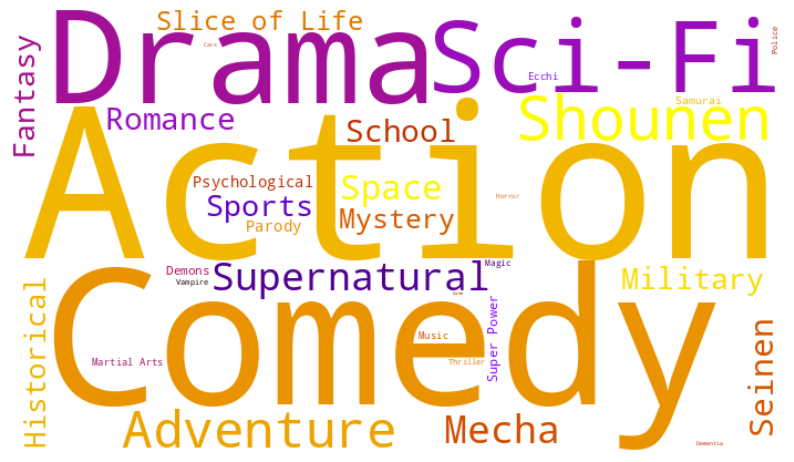

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [72]:
get_user_prefrence(11880,rating_df,df,plot=True)

In [73]:
find_similar_users(int(11800),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,1697,0.325747
8,6252,0.325059
7,12696,0.300443
6,925,0.292468
5,5128,0.291497
4,7348,0.289584
3,10321,0.282889
2,13334,0.269485
1,13241,0.267983
0,14126,0.267931


In [74]:
def get_user_recommendation(similar_users,user_pref,df,sypnopsis_df,rating_df,n=10):
    recommended_animes = []
    anime_list= []

    for user_id in similar_users.similar_users.values:
        pref_list=get_user_prefrence(int(user_id),rating_df,df)

        pref_list=pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]
        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list=pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i,anime_name in enumerate(sorted_list.index):
            n_user_pref =sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name,str):
                frame =getAnimeFrame(anime_name,df)
                anime_id= frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id),sypnopsis_df)
                
                recommended_animes.append(
                    {
                        "n":n_user_pref,
                        "anime_name":anime_name,
                        "Genre":genre,
                        "Synopsis":synopsis
                        
                    }
                )
    return pd.DataFrame(recommended_animes).head(n)
        

In [82]:
similar_users = find_similar_users(int(11883),user_weights,user2user_encoded,user2user_decoded)

Error shapes (4203,128) and (1,4203,128) not aligned: 128 (dim 1) != 4203 (dim 1)


In [83]:
similar_users

In [76]:
user_pref = get_user_prefrence(11880,rating_df,df)

In [77]:
get_user_recommendation(similar_users,user_pref,df,sypnopsis_df,rating_df)

,n,anime_name,Genre,Synopsis
0,9,Spirited Away,"Adventure, Supernatural, Drama","Stubborn, spoiled, and naïve, 10-year-old Chihiro Ogino is less than pleased when she and her parents discover an abandoned amusement park on the way to their new house. Cautiously venturing inside, she realizes that there is more to this place than meets the eye, as strange things begin to happen once dusk falls. Ghostly apparitions and food that turns her parents into pigs are just the start—Chihiro has unwittingly crossed over into the spirit world. Now trapped, she must summon the courage to live and work amongst spirits, with the help of the enigmatic Haku and the cast of unique characters she meets along the way. Vivid and intriguing, Sen to Chihiro no Kamikakushi tells the story of Chihiro's journey through an unfamiliar world as she strives to save her parents and return home."
1,8,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
2,8,The Devil is a Part-Timer!,"Comedy, Demons, Supernatural, Romance, Fantasy","Striking fear into the hearts of mortals, the Demon Lord Satan begins to conquer the land of Ente Isla with his vast demon armies. However, while embarking on this brutal quest to take over the continent, his efforts are foiled by the hero Emilia, forcing Satan to make his swift retreat through a dimensional portal only to land in the human world. Along with his loyal general Alsiel, the demon finds himself stranded in modern-day Tokyo and vows to return and complete his subjugation of Ente Isla—that is, if they can find a way back! Powerless in a world without magic, Satan assumes the guise of a human named Sadao Maou and begins working at MgRonald's—a local fast-food restaurant—to make ends meet. He soon realizes that his goal of conquering Ente Isla is just not enough as he grows determined to climb the corporate ladder and become the ruler of Earth, one satisfied customer at a time! Whether it's part-time work, household chores, or simply trying to pay the rent on time, Hataraku Maou-sama! presents a hilarious view of the most mundane aspects of everyday life, all through the eyes of a hapless demon lord."
3,8,"No Game, No Life","Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy","No Game No Life is a surreal comedy that follows Sora and Shiro, shut-in NEET siblings and the online gamer duo behind the legendary username ""Blank."" They view the real world as just another lousy game; however, a strange e-mail challenging them to a chess match changes everything—the brother and sister are plunged into an otherworldly realm where they meet Tet, the God of Games. The mysterious god welcomes Sora and Shiro to Disboard, a world where all forms of conflict—from petty squabbles to the fate of whole c

### Hybrid Recommender System

In [94]:
def hybrid_recommendation(user_id,user_weight = 0.5,content_weight = 0.5):

    ## Collabarative filtering
    similar_users = find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_prefrence(user_id,rating_df,df)
    user_recommended_anime_list = get_user_recommendation(similar_users,user_pref,df,sypnopsis_df,rating_df)


    user_recommended_anime_list = user_recommended_anime_list["anime_name"].to_list()
    print(user_recommended_anime_list)
    # content recommendation
    content_recommendation_animes =[]
    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime,anime_weights,anime2anime_encoded,anime2anime_decoded,df,sypnopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommendation_animes.extend(similar_animes["name"].tolist())
        
        else:
            print(f"No similar anime found{anime}")
    
    combined_scores ={}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0)+user_weight
    
    for anime in content_recommendation_animes:
        combined_scores[anime]= combined_scores.get(anime,0) + content_weight

    sorted_animes = sorted(combined_scores.items(),key=lambda x:x[1],reverse=True)
    return [anime for anime,score in sorted_animes[:10]]

In [95]:
hybrid_recommendation(11880)

['Spirited Away', 'No Game, No Life', 'Death Note', 'One Piece', 'Toradora!', "Howl's Moving Castle", 'Code Geass:Lelouch of the Rebellion R2', 'Time of Eve', 'The Pet Girl of Sakurasou', 'The World God Only Knows II']
Anime closest to Spirited Away
Anime closest to No Game, No Life
Anime closest to Death Note
Anime closest to One Piece
Anime closest to Toradora!
Anime closest to Howl's Moving Castle
Anime closest to Code Geass:Lelouch of the Rebellion R2
Anime closest to Time of Eve
Anime closest to The Pet Girl of Sakurasou
Anime closest to The World God Only Knows II


['Spirited Away',
 'No Game, No Life',
 'Death Note',
 'One Piece',
 'Toradora!',
 "Howl's Moving Castle",
 'Code Geass:Lelouch of the Rebellion R2',
 'Time of Eve',
 'The Pet Girl of Sakurasou',
 'The World God Only Knows II']